## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn import svm
import pandas as pd
from decimal import Decimal
% matplotlib inline

## Load Data

In [4]:
data = np.loadtxt("parkinsons.data.txt", delimiter=",")
columnfile = open("columns.txt", "r")
cols = np.array(columnfile.readlines())
columnfile.close()
X = np.array([data[:,i] for i in range(0,16)]+[data[:,i] for i in range(17,23)]).T
Ydata = data[:,16]
meanY = np.mean(Ydata)
Y = Ydata-meanY

# PCA with SVM

### Find PCA number of components

In [3]:
pcadata = PCA(0.99) # Float number for n_components defines component number by % var explained
data = pcadata.fit_transform(scale(X))
print('The number of compenents that explains 99% of variance using PCA is ' + str(data.shape[1]))

The number of compenents that explains 99% of variance using PCA is 12


### Plot the explained variance for the first 10 principle components

In [4]:
pca = PCA(n_components = 10)
pca.fit(scale(X))
var = pca.explained_variance_

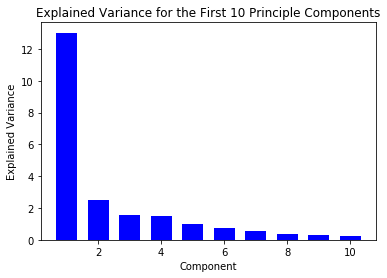

In [5]:
plt.bar(range(1,len(var)+1), var, 1/1.5, color="b")
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for the First 10 Principle Components');
plt.savefig('Explained Variance for PCA')

### Make the scores plot for PCA

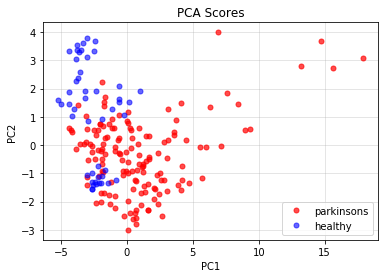

In [6]:
maska = Ydata==1
maskb = Ydata==0
x = data[:,0]
y = data[:,1]
plt.plot(x[maska],y[maska],'.',markersize = 10,c='r', alpha = 0.7, label = 'parkinsons')
plt.plot(x[maskb],y[maskb],'.',markersize = 10,c='b', alpha = 0.6, label = 'healthy')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA Scores')
plt.grid(alpha = 0.4)
plt.legend();
plt.savefig('PCA Scores.jpg')

### Using SVM To Classify Scores

Accuracy = 90.76923076923077 Kernel: poly Degree = 3
Sensitivity = 100.0 Specificity = 62.5


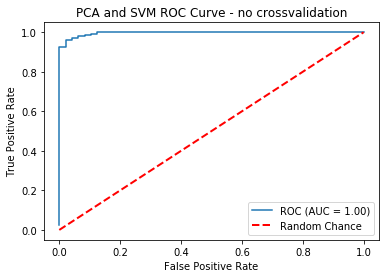

In [7]:
def PCASVM(pca, kernel, degree, X, Yscale, Y):
    xSc = pca.fit_transform(scale(X))
    classifier = svm.SVC(kernel = kernel, degree = degree, probability = True)
    proba = classifier.fit(xSc, Y).predict_proba(xSc)
    prediction = classifier.fit(xSc, Y).predict(xSc)
    acc = metrics.accuracy_score(Y, prediction)
    fpr, tpr, thresholds = metrics.roc_curve(Y, proba[:, 1])
    roc_auc = round(Decimal(metrics.auc(fpr, tpr)),2)
    return [acc, fpr, tpr, roc_auc,prediction]

accuracy = 0
result = ''
degree = 0
kernels = ['linear','poly','sigmoid'] #,'rbf'] rbf gave overfitting
prediction = []
for kl in kernels:
    pca = PCA(0.99)
    if kl == 'poly':
        for d in range(2,5):
            [acc, fprate, tprate, auc,predict] = PCASVM(pca, kl, d, X, Y, Ydata)
            if acc > accuracy:
                fpr = fprate
                tpr = tprate
                roc_auc = auc
                result = 'poly'
                degree = d
                accuracy = acc
                prediction = predict
    else:
        [acc, fprate, tprate, auc,predict] = PCASVM(pca, kl, 0, X, Y, Ydata)
        if acc > accuracy:
            fpr = fprate
            tpr = tprate
            roc_auc = auc
            result = kl
            degree = 0
            accuracy = acc
            prediction = predict
            
print('Accuracy = ' + str(accuracy*100), 'Kernel: ' + str(result), 'Degree = ' +str(degree))
tn = 0; tp = 0; n = 0; p = 0
for i in range(len(prediction)):
    if Ydata[i] == 0: n+=1
    if Ydata[i] == 1: p+=1
    if prediction[i] == Ydata[i] == 0:
        tn+=1
    if prediction[i] == Ydata[i] == 1:
        tp+=1
sensitivity = (tp/p)*100
specificity = (tn/n)*100
print('Sensitivity = '+str(sensitivity), 'Specificity = ' +str(specificity))
plt.plot(fpr, tpr, label=('ROC (AUC = '+str(roc_auc)+')'))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA and SVM ROC Curve - no crossvalidation')
plt.legend(loc="lower right")
plt.savefig('ROC Curve for SVM.jpg')

### K-fold Crossvalidation with SVM Classification

Accuracy = 86.66666666666667
Sensitivity = 98.63945578231292 Specificity = 50.0


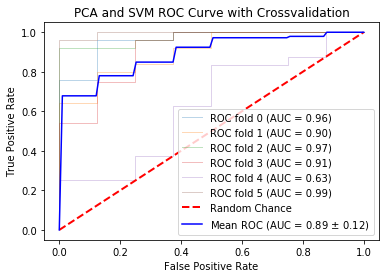

In [8]:
pcacv = PCA(0.99)
xSc = pcacv.fit_transform(scale(X))
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='poly',degree = 3, probability=True)

tprs = []
aucs = []
predictions = []
true_vals = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
tp = 0; tn = 0; n = 0; p = 0
for train, test in cv.split(xSc, Ydata):
    true_vals = true_vals + list(Ydata[test])
    probas_ = classifier.fit(xSc[train], Ydata[train]).predict_proba(xSc[test])
    prediction = classifier.fit(xSc[train], Ydata[train]).predict(xSc[test])
    predictions = predictions + list(prediction.flatten())
    fpr, tpr, thresholds = metrics.roc_curve(Ydata[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = round(Decimal(metrics.auc(fpr, tpr)),2)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw =1, alpha = 0.3, label='ROC fold '+str(i)+' (AUC = '+str(roc_auc)+')')
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random Chance')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
acc = metrics.accuracy_score(true_vals, predictions)
for j in range(len(predictions)):
        if true_vals[j] == 0: n+=1
        if true_vals[j] == 1: p+=1
        if predictions[j] == true_vals[j] == 0:
            tn+=1
        if predictions[j] == true_vals[j] == 1:
            tp+=1
sensitivity = (tp/p)*100
specificity = (tn/n)*100
print('Accuracy = '+str(acc*100))
print('Sensitivity = '+str(sensitivity), 'Specificity = ' +str(specificity))
plt.plot(mean_fpr, mean_tpr, color='b',label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA and SVM ROC Curve with Crossvalidation')
plt.legend(loc="lower right");
plt.savefig('ROC Curve for SVM with Crossvalidation.jpg')

# PLS-DA Classification

### Find optimum number of compenents using R^2 (perhaps not the best method)

In [9]:
import operator
percent_variance = {}; Rsq = {}
for comp in range(1,23):
    PLS = PLSRegression(n_components = comp, max_iter = 1000, scale = True)
    xSc, ySc = PLS.fit_transform(X,Y)
    prediction = PLS.predict(X)
    prediction_mean = np.mean(prediction)
    Y_m = [0. if i <= prediction_mean else 1. for i in prediction]
    a = sum([(Y_m[i]-Ydata[i])**2 for i in range(len(Y_m))])
    b = sum([Ydata[k]**2 for k in range(len(Ydata))])
    percent_variance[comp] = 1-(a/b)
print(max(percent_variance.items(), key=operator.itemgetter(1)))

(10, 0.7074829931972789)


### Make the scores plot for PLSR

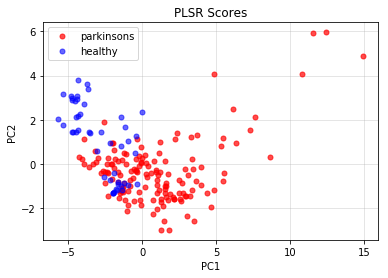

In [10]:
PLS = PLSRegression(n_components = 10, max_iter = 1000, scale = True)
xSc, ySc = PLS.fit_transform(X,Y)
xVals = xSc[:,0]
yVals = xSc[:,1]
plt.plot(xVals[maska],yVals[maska],'.',markersize = 10,c='r', alpha = 0.7, label = 'parkinsons')
plt.plot(xVals[maskb],yVals[maskb],'.',markersize = 10,c='b', alpha = 0.6, label = 'healthy')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PLSR Scores')
plt.grid(alpha = 0.4)
plt.legend();
plt.savefig('PLSR Score.jpg')

### Find Number of Components for PLS-DA

Accuracy = 91.7948717948718 Number of Components = 14


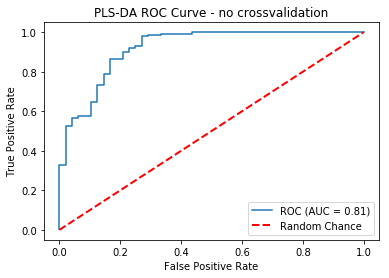

In [11]:
def PLSDA(X,Yscale,Y,comp):
    pls = PLSRegression(n_components = comp, max_iter = 1000, scale = True)
    pls.fit(X,Yscale)
    prediction = pls.predict(X)
    fpr, tpr, thresholds = metrics.roc_curve(Y, prediction)
    roc_auc = round(Decimal(metrics.auc(fpr, tpr)),2)
    accuracy = 0
    for thres in thresholds:
        Y_m = [0. if i <= thres else 1. for i in prediction]
        acc = metrics.accuracy_score(Ydata, Y_m)
        if acc > accuracy:
            accuracy = acc
    return [accuracy, fpr, tpr, auc]

accuracy = 0
component = 0
for comp in range(1,23): # loop through components 5 below and 5 above found optimal num components
    [acc, fprate, tprate, auc] = PLSDA(X,Y,Ydata,comp)
    if acc > accuracy:
        accuracy = acc
        fprp = fprate
        tprp = tprate
        roc_aucp = auc
        component = comp
print('Accuracy = ' +str(accuracy*100), 'Number of Components = ' + str(component))
plt.plot(fprp, tprp, label='ROC (AUC = '+str(roc_aucp)+')')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PLS-DA ROC Curve - no crossvalidation')
plt.legend(loc="lower right");
plt.savefig('ROC Curve for PLS-DA - 14 components')

### ROC Curve for PLS-DA after kfold crossvalidation

Accuracy = 87.17948717948718
Sensitivity = 95.23809523809523 Specificity = 62.5


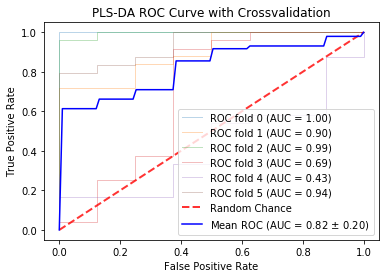

In [12]:
cv2 = StratifiedKFold(n_splits=6)
tprs2 = []
aucs2 = []
true_vals2 = []
predictions2 = []
mean_fpr2 = np.linspace(0, 1, 100)
tp = 0; tn = 0; n = 0; p = 0
i = 0
for train, test in cv2.split(X, Ydata):
    true_vals2 = true_vals2 + list(Ydata[test])
    Y = Ydata-np.mean(Ydata)
    plscv = PLSRegression(n_components = 14, max_iter = 1000, scale = True)
    prediction = plscv.fit(X[train],Y[train]).predict(X[test])
    fpr2, tpr2, thresholds2 = metrics.roc_curve(Ydata[test], prediction)
    Y_model = []
    accuracy = 0
    for thres in thresholds2:
        Y_m = [0. if i <= thres else 1. for i in prediction]
        acc = metrics.accuracy_score(Ydata[test], Y_m)
        if acc > accuracy:
            accuracy = acc
            Y_model = Y_m
    predictions2 = predictions2 + Y_model
    tprs2.append(interp(mean_fpr2, fpr2, tpr2))
    tprs2[-1][0] = 0.0
    roc_auc2 = round(Decimal(metrics.auc(fpr2, tpr2)),2)
    aucs2.append(roc_auc2)
    plt.plot(fpr2, tpr2, lw =1, alpha = 0.3, label='ROC fold '+str(i)+' (AUC = '+str(roc_auc2)+')')
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance', alpha=.8)
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr2[-1] = 1.0
mean_auc2 = metrics.auc(mean_fpr2, mean_tpr2)
acc = metrics.accuracy_score(true_vals2, predictions2)
for j in range(len(predictions2)):
        if true_vals2[j] == 0: n+=1
        if true_vals2[j] == 1: p+=1
        if predictions2[j] == true_vals2[j] == 0:
            tn+=1
        if predictions2[j] == true_vals2[j] == 1:
            tp+=1
sensitivity = (tp/p)*100
specificity = (tn/n)*100
print('Accuracy = '+str(acc*100))
print('Sensitivity = '+str(sensitivity), 'Specificity = ' +str(specificity))
std_auc2 = np.std(aucs2)
plt.plot(mean_fpr2, mean_tpr2, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc2, std_auc2))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PLS-DA ROC Curve with Crossvalidation')
plt.legend(loc="lower right")
plt.savefig('ROC Curve for PLS-DA with Crossvalidation-14comp.jpg')